# Train TLRY Model
This notebook will develop and train a neural network to predict the percent change in the TLRY price.
It will utilize grid search to find the best hyperparameters

## Enviornment setups

In [1]:
# Import packages

# General Utility
from datetime import datetime
import datetime, time
from datetime import timedelta

# Data processing
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import RobustScaler

# Plotting
import matplotlib.pyplot as plt

import torch

# Diamond-Hands
import sys
sys.path.append('../Packages/')
import diamond_hands as dh

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ntnay\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
tickr = 'TLRY'

In [3]:
# Data Locations
processed_input_dir = '../../Data/ProcessedInputs/'
model_dir = '../../Data/Models/'
grid_result_dir = model_dir+tickr+'/'
fine_grid_result_dir = model_dir+tickr+'/Fine/'
pred_dir = '../../Data/Predictions/'
final_model_dir = '../../Data/Models/Final/'

In [4]:
TRAIN_ON_GPU, TRAIN_ON_MULTI_GPUS = dh.setupPytorch()

Training on GPU!


In [5]:
with open(processed_input_dir+tickr+'_input_data.bin','rb') as f:
    df = pickle.load(f)
with open(processed_input_dir+tickr+'_output_data.bin','rb') as f:
    output_data = pickle.load(f)
with open(model_dir+tickr+'_scaler.bin','rb') as f:
    scaler = pickle.load(f)

In [6]:
df = df[:-1]

In [7]:
df['2021-03-01':]

,P_Change,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,...,Tomorrow_Tickr_#Pos,Tomorrow_Tickr_W#Neg,Tomorrow_Tickr_W#Neu,Tomorrow_Tickr_W#Pos,Tomorrow_Tickr_%Neg,Tomorrow_Tickr_%Neu,Tomorrow_Tickr_%Pos,Tomorrow_Tickr_W%Neg,Tomorrow_Tickr_W%Neu,Tomorrow_Tickr_W%Pos
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,0.704141,-2.198621,3.840804,0.434822,-11.824755,0.096998,0.216593,-0.015367,1.643320,-0.387058,...,17.0,3.0,105.0,96.0,0.045455,0.568182,0.386364,0.014019,0.490654,0.448598
2021-03-02,0.333478,-2.318495,3.973105,0.287202,-9.813691,-0.112200,0.385265,-0.128824,3.142220,-0.387058,...,35.0,40.0,337.0,187.0,0.055556,0.620370,0.324074,0.069686,0.587108,0.325784
2021-03-03,-0.798119,-2.355454,3.911115,0.051086,-8.691638,-1.062600,-0.387707,-0.420969,0.234159,-0.387337,...,10.0,27.0,64.0,74.0,0.086957,0.478261,0.434783,0.163636,0.387879,0.448485
2021-03-04,-1.050133,-2.413931,3.814233,0.044350,-9.313857,-0.720748,-0.586461,-0.243252,-7.934694,-0.387337,...,2.0,13.0,36.0,4.0,0.272727,0.545455,0.181818,0.245283,0.679245,0.075472
2021-03-05,-0.702802,-2.371609,3.712272,-0.008654,-8.744213,-0.462568,-0.941826,-0.226582,-10.089244,-0.387337,...,3.0,3.0,9.0,14.0,0.200000,0.200000,0.600000,0.115385,0.346154,0.538462
2021-03-08,1.108170,-2.352245,3.783776,0.087296,-7.089609,-0.932395,0.342109,-0.212312,-1.334433,-0.386915,...,3.0,0.0,24.0,19.0,0.000000,0.571429,0.428571,0.000000,0.452830,0.358491
2021-03-09,2.308344,-2.323419,3.850728,-0.018560,-5.113629,-0.703809,0.388423,-0.170322,5.913139,-0.385850,...,10.0,4.0,26.0,61.0,0.133333,0.200000,0.666667,0.043956,0.285714,0.670330
2021-03-10,-0.978698,-2.383574,3.746636,-0.427118,-4.622711,-0.310102,0.282462,-0.126111,3.206900,-0.385850,...,8.0,7.0,103.0,34.0,0.052632,0.526316,0.421053,0.046053,0.677632,0.223684
2021-03-11,0.990181,-2.228657,3.889154,-1.188607,0.279120,0.057390,0.230559,-0.072975,15.799460,-0.385850,...,42.0,61.0,704.0,271.0,0.040650,0.617886,0.341463,0.057985,0.669202,0.257605


In [8]:
n_test=37

## Grid Search

In [9]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [1,5,10,20,40,60]
n_hidden = [10,50,100]
n_layers = [2,3]
drop_prob = [0.1,0.25,0.5]
lr = [0.001,0.01]
clip = [1,5,10]
batch_size = [100]

In [10]:
# use grid search to optimize hyperparameters
grid_result = []
dh.gridSearch(grid_results = grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=10,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 648 different configurations.
Iteration: 1 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 2 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 3 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 4 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 5 |periods: 40|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 1s
Iteration: 6 |periods: 60|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 1s
Iteration: 7 |periods: 1|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 8 |periods: 5|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 9 |periods: 10|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 10 |periods: 20

Training complete in 0m 0s
Iteration: 80 |periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 81 |periods: 10|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 82 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 1s
Iteration: 83 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 1s
Iteration: 84 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 1s
Iteration: 85 |periods: 1|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 86 |periods: 5|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 87 |periods: 10|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 88 |periods: 20|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 1s
Iteration: 89 |periods: 40|hidden: 100|layers

Training complete in 0m 1s
Iteration: 160 |periods: 20|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 1s
Iteration: 161 |periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 1s
Iteration: 162 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 1s
Iteration: 163 |periods: 1|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 0s
Iteration: 164 |periods: 5|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 1s
Iteration: 165 |periods: 10|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 1s
Iteration: 166 |periods: 20|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 1s
Iteration: 167 |periods: 40|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 1s
Iteration: 168 |periods: 60|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 1s
Iteration: 169 |periods: 1|hidden: 5

Training complete in 0m 1s
Iteration: 240 |periods: 60|hidden: 10|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 1s
Iteration: 241 |periods: 1|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 0s
Iteration: 242 |periods: 5|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 1s
Iteration: 243 |periods: 10|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 1s
Iteration: 244 |periods: 20|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 1s
Iteration: 245 |periods: 40|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 1s
Iteration: 246 |periods: 60|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 1s
Iteration: 247 |periods: 1|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 1s
Iteration: 248 |periods: 5|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 1s
Iteration: 249 |periods: 10|hidden: 100

Training complete in 0m 1s
Iteration: 319 |periods: 1|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 1s
Iteration: 320 |periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 1s
Iteration: 321 |periods: 10|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 1s
Iteration: 322 |periods: 20|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 1s
Iteration: 323 |periods: 40|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 2s
Iteration: 324 |periods: 60|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 2s
Iteration: 325 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 326 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 327 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 1s
Iteration: 328 |periods: 20|hidden: 10

Training complete in 0m 0s
Iteration: 399 |periods: 10|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 400 |periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 1s
Iteration: 401 |periods: 40|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 1s
Iteration: 402 |periods: 60|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 1s
Iteration: 403 |periods: 1|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 404 |periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 405 |periods: 10|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 1s
Iteration: 406 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 1s
Iteration: 407 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 1s
Iteration: 408 |periods: 60|hidden: 50|layers: 2

Training complete in 0m 1s
Iteration: 478 |periods: 20|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 1s
Iteration: 479 |periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 1s
Iteration: 480 |periods: 60|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 1s
Iteration: 481 |periods: 1|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 0s
Iteration: 482 |periods: 5|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 0s
Iteration: 483 |periods: 10|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 0s
Iteration: 484 |periods: 20|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 1s
Iteration: 485 |periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 1s
Iteration: 486 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 1s
Iteration: 487 

Training complete in 0m 0s
Iteration: 556 |periods: 20|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 1s
Iteration: 557 |periods: 40|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 1s
Iteration: 558 |periods: 60|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 1s
Iteration: 559 |periods: 1|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 560 |periods: 5|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 561 |periods: 10|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 1s
Iteration: 562 |periods: 20|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 1s
Iteration: 563 |periods: 40|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 1s
Iteration: 564 |periods: 60|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 1s
Iteration: 565 |periods: 1|hidden: 5

Training complete in 0m 1s
Iteration: 635 |periods: 40|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 1s
Iteration: 636 |periods: 60|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 1s
Iteration: 637 |periods: 1|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 638 |periods: 5|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 1s
Iteration: 639 |periods: 10|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 1s
Iteration: 640 |periods: 20|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 1s
Iteration: 641 |periods: 40|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 1s
Iteration: 642 |periods: 60|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 1s
Iteration: 643 |periods: 1|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 1s
Iteration: 644 |periods: 5|hidden: 100|

In [11]:
with open(model_dir+tickr+'_grid_search_result.bin','wb') as f:
    pickle.dump(grid_result,f)

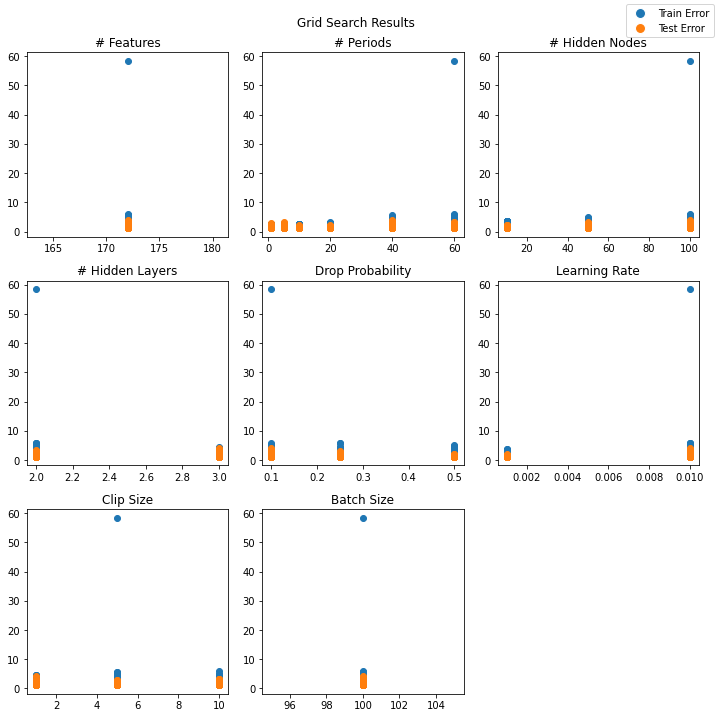

In [12]:
dh.visualizeGridSearch(grid_result)

In [13]:
resultdf = dh.resultDF(grid_result)

In [14]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size
33,2.535575,1.036708,172.0,20.0,100.0,3.0,0.10,0.001,1.0,100.0
459,2.599279,1.082178,172.0,20.0,50.0,3.0,0.10,0.001,10.0,100.0
600,2.232566,1.089676,172.0,1.0,50.0,3.0,0.25,0.010,10.0,100.0
446,2.237154,1.094811,172.0,10.0,100.0,2.0,0.10,0.001,10.0,100.0
230,2.219906,1.099507,172.0,10.0,100.0,2.0,0.10,0.001,5.0,100.0
...,...,...,...,...,...,...,...,...,...,...
568,3.670526,3.178152,172.0,40.0,50.0,3.0,0.10,0.010,10.0,100.0
593,5.918233,3.216332,172.0,60.0,100.0,2.0,0.25,0.010,10.0,100.0
553,2.099951,3.253562,172.0,5.0,100.0,2.0,0.10,0.010,10.0,100.0
143,2.561374,3.351961,172.0,60.0,100.0,3.0,0.10,0.010,1.0,100.0


## Fine Grid Search

In [15]:
best_model_id = sorted_results.index[0]

In [16]:
with open(grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()


StockLSTM(
  (lstm): LSTM(172, 100, num_layers=3, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=2000, out_features=1, bias=True)
)

In [17]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [model.n_periods]
n_hidden = [model.n_hidden]
n_layers = [model.n_layers]
drop_prob = [model.drop_prob]
lr = [model.lr]
clip = [model.clip]
batch_size = [1,5,10,20,40,60,120,240]
epochs = [10,25,50,100,250,500]

In [18]:
# use fine grid search to optimize hyperparameters
fine_grid_result = []
dh.finegridSearch(grid_results = fine_grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=epochs,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=fine_grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 48 different configurations.
Iteration: 1 |epochs: 10|periods: 20|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 38s
Iteration: 2 |epochs: 10|periods: 20|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 8s
Iteration: 3 |epochs: 10|periods: 20|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 4 |epochs: 10|periods: 20|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 5 |epochs: 10|periods: 20|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 1s
Iteration: 6 |epochs: 10|periods: 20|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 1s
Iteration: 7 |epochs: 10|periods: 20|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 1s
Iteration: 8 |epochs: 10|periods: 20|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 1s
Iteration: 9 |epochs: 25|per

In [19]:
with open(model_dir+tickr+'fine_grid_search_result.bin','wb') as f:
    pickle.dump(fine_grid_result,f)

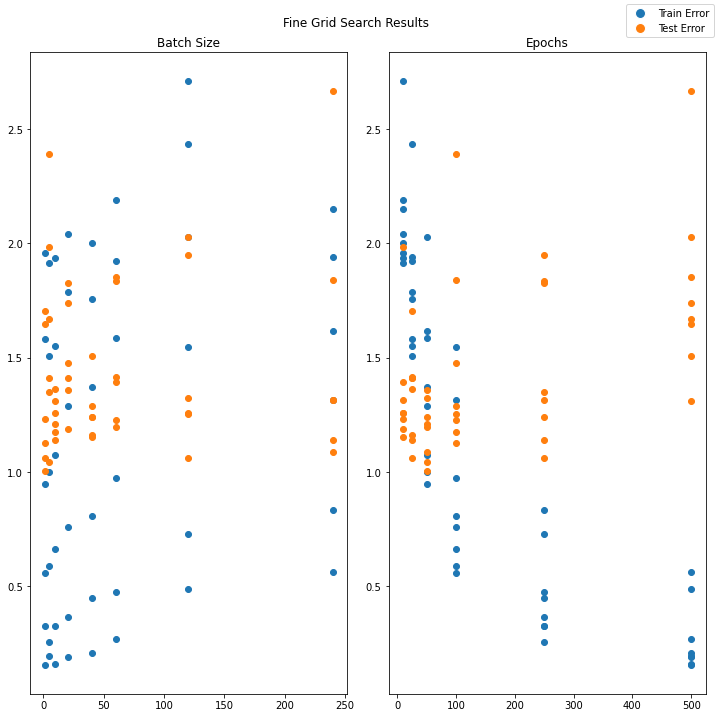

In [20]:
dh.visualizeFineGridSearch(fine_grid_result)

In [21]:
resultdf = dh.resultDFFine(fine_grid_result)

In [22]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size,Epochs
16,0.949140,1.003678,172.0,20.0,100.0,3.0,0.1,0.001,1.0,1.0,50.0
17,1.002213,1.045996,172.0,20.0,100.0,3.0,0.1,0.001,1.0,5.0,50.0
32,0.325341,1.063043,172.0,20.0,100.0,3.0,0.1,0.001,1.0,1.0,250.0
14,2.432750,1.063328,172.0,20.0,100.0,3.0,0.1,0.001,1.0,120.0,25.0
23,1.617669,1.085817,172.0,20.0,100.0,3.0,0.1,0.001,1.0,240.0,50.0
24,0.557817,1.126447,172.0,20.0,100.0,3.0,0.1,0.001,1.0,1.0,100.0
34,0.328792,1.139159,172.0,20.0,100.0,3.0,0.1,0.001,1.0,10.0,250.0
15,1.939890,1.139779,172.0,20.0,100.0,3.0,0.1,0.001,1.0,240.0,25.0
4,1.999462,1.152564,172.0,20.0,100.0,3.0,0.1,0.001,1.0,40.0,10.0
12,1.758057,1.162647,172.0,20.0,100.0,3.0,0.1,0.001,1.0,40.0,25.0


## Evaluate Final Model

In [23]:
best_model_id = sorted_results.index[0]
with open(fine_grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()

StockLSTM(
  (lstm): LSTM(172, 100, num_layers=3, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=2000, out_features=1, bias=True)
)

Training RMSE: 1.6884819923719594
Test RMSE: 1.6223721821555455
Training MAE: 0.6641150546154372
Test MAE: 1.3316053012918772
Training - Above Error: $0.65 (46.54%) Below Error: $-0.67 (53.46%)
Test - Above Error: $1.36 (37.84%) Below Error: $-1.31 (62.16%)


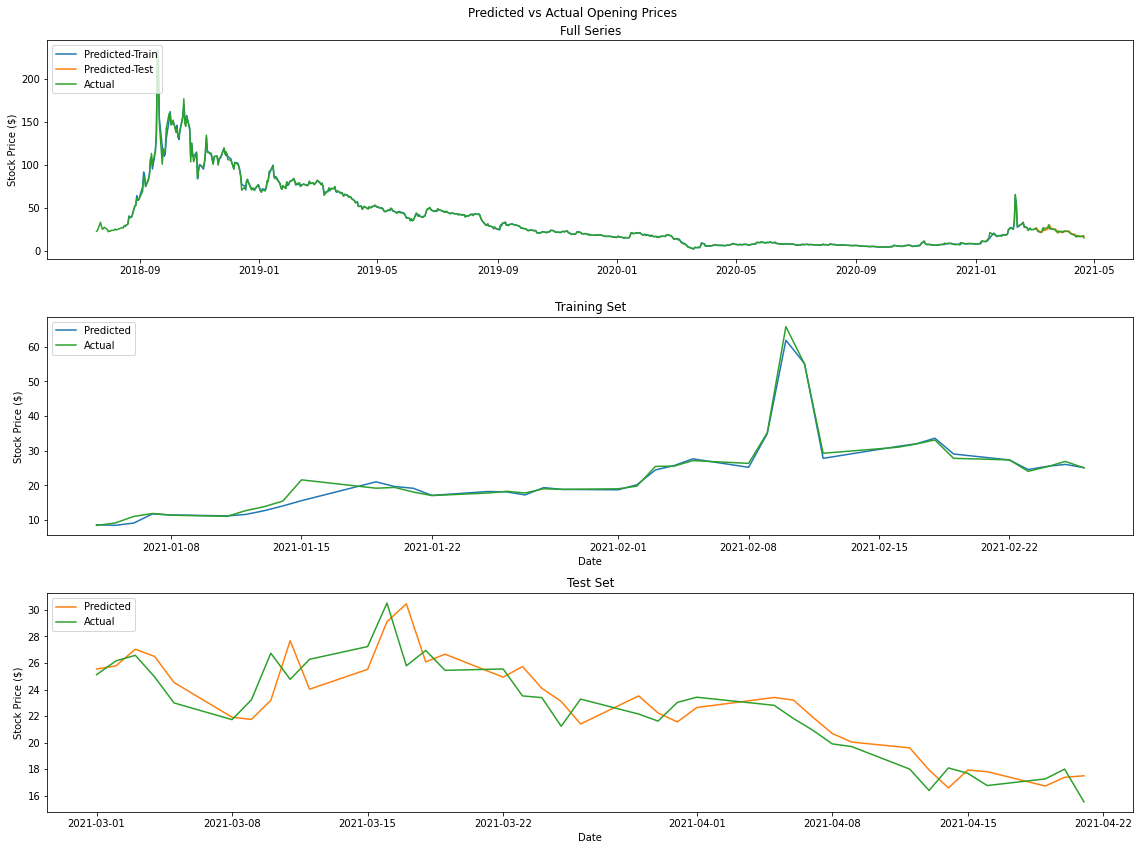

In [24]:
preds = dh.evaluateModel(model=model,
             input_data=df,
             output_data=output_data[:-1],
             scaler=scaler,
             n_steps_in=model.n_periods,
             n_steps_out=1,
             n_test=n_test)

In [25]:
preds.tail()

,Open,Raw_Predictions,Prediction_Type,Predicted
Date,,,,
2021-04-15,17.68,0.007221,Test,17.928075
2021-04-16,16.76,-0.002218,Test,17.807667
2021-04-19,17.26,0.007092,Test,16.722825
2021-04-20,18.00,-0.028027,Test,17.382404
2021-04-21,15.53,0.046819,Test,17.495516


In [26]:
with open(pred_dir+tickr+'_pred.bin','wb') as f:
    pickle.dump(preds,f)

In [27]:
with open(final_model_dir+tickr+'_model.model','wb') as f:
    torch.save(model,f)